In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, roc_auc_score, mean_absolute_error, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from lifelines import CoxPHFitter

## Prepare Data
Separate out the outcomes. Keep only mean and last BMI. 

Split into train and test datasets.

Standardize the lab values, age at first diagnosis, and BMI (train the scaler on the training set and then use it on the test set).

In [2]:
df = pd.read_csv("/nobackup/users/ericason/mlhc-final-project/clean_data/nafl/combined.large.nafl.csv", header=0, delimiter=",")
df.head()

,StudyID,Lab_10466-1,Lab_13362-9,Lab_13457-7,Lab_14338-8,Lab_14957-5,Lab_14959-1,Lab_16362-6,Lab_1742-6,Lab_1751-7,...,Code_Z98.61,Code_Z98.82,Code_Z98.84,Code_Z98.89,Code_Z98.890,Code_Z98.891,Code_Z99.11,Code_Z99.2,Code_Z99.81,Code_Z99.89
0,1,11.200000,0.0,0.0,0.0,0.0,0.0,0.0,13.000000,4.166667,...,False,False,False,False,False,False,False,False,False,False
1,3,14.444444,0.0,0.0,0.0,0.0,0.0,0.0,34.000000,4.200000,...,False,False,False,False,False,False,False,False,False,False
2,4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,False,False,False,False,False,False,False,False,False,True
3,6,12.600000,0.0,58.0,0.0,0.0,0.0,0.0,13.333333,4.433333,...,False,False,False,False,False,False,False,False,False,False
4,11,20.166667,0.0,0.0,0.0,0.0,0.0,0.0,19.200000,4.300000,...,False,False,False,False,True,False,False,False,True,False


In [3]:
# make lists of important columns
outcome_cols = ["Outcome", "DaysUntilFirstProgression"] # outcomes
drop_cols = ["StudyID"] # columns to drop that are not outcome
# columns that should be scaled later
numerical_cols = [x for x in df.columns if ("lab" in x.lower()) or ("age" in x.lower()) or ("bmi" in x.lower() and "category" not in x.lower())]


In [4]:
# make features dataframe
X = df.drop(columns=outcome_cols + drop_cols)
X.head()

,Lab_10466-1,Lab_13362-9,Lab_13457-7,Lab_14338-8,Lab_14957-5,Lab_14959-1,Lab_16362-6,Lab_1742-6,Lab_1751-7,Lab_1761-6,...,Code_Z98.61,Code_Z98.82,Code_Z98.84,Code_Z98.89,Code_Z98.890,Code_Z98.891,Code_Z99.11,Code_Z99.2,Code_Z99.81,Code_Z99.89
0,11.200000,0.0,0.0,0.0,0.0,0.0,0.0,13.000000,4.166667,0.0,...,False,False,False,False,False,False,False,False,False,False
1,14.444444,0.0,0.0,0.0,0.0,0.0,0.0,34.000000,4.200000,0.0,...,False,False,False,False,False,False,False,False,False,False
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,False,False,False,False,False,False,False,False,False,True
3,12.600000,0.0,58.0,0.0,0.0,0.0,0.0,13.333333,4.433333,0.0,...,False,False,False,False,False,False,False,False,False,False
4,20.166667,0.0,0.0,0.0,0.0,0.0,0.0,19.200000,4.300000,0.0,...,False,False,False,False,True,False,False,False,True,False


In [5]:
# make outcome dataframe (including both linear and logistic outcomes)
Y = df[["DaysUntilFirstProgression", "Outcome"]]

In [6]:
# make train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}, Y_train shape: {Y_train.shape}, Y_test shape: {Y_test.shape}')

X_train shape: (8107, 2850), X_test shape: (3475, 2850), Y_train shape: (8107, 2), Y_test shape: (3475, 2)


In [7]:
# standardize numerical columns
scaler = StandardScaler()
X_train_scaled = X_train
# scale numerical columns and replace them in the original dataframe
X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols]) 
X_train_scaled.head()

,Lab_10466-1,Lab_13362-9,Lab_13457-7,Lab_14338-8,Lab_14957-5,Lab_14959-1,Lab_16362-6,Lab_1742-6,Lab_1751-7,Lab_1761-6,...,Code_Z98.61,Code_Z98.82,Code_Z98.84,Code_Z98.89,Code_Z98.890,Code_Z98.891,Code_Z99.11,Code_Z99.2,Code_Z99.81,Code_Z99.89
940,1.067270,-0.027232,-0.494022,-0.103991,-0.062287,-0.046518,-0.06046,-0.164076,-0.009021,-0.084797,...,False,False,False,False,False,False,False,False,False,False
4256,-0.342292,-0.027232,-0.494022,-0.103991,-0.099132,-0.099867,-0.06046,-0.463047,-0.011862,-0.084797,...,False,False,False,False,False,False,False,False,False,False
5227,0.713220,-0.027232,-0.494022,-0.103991,-0.071293,-0.080779,-0.06046,-0.521180,-0.012572,-0.084797,...,False,False,False,False,False,False,False,False,False,True
4477,-2.805153,-0.027232,2.040337,-0.103991,-0.099132,-0.099867,-0.06046,-0.438132,-0.003338,-0.084797,...,False,False,False,False,False,False,False,False,False,False
6639,0.189521,-0.027232,-0.494022,-0.103991,-0.033630,-0.064627,-0.06046,-0.504570,-0.021807,-0.084797,...,False,False,True,False,False,False,False,False,False,False


In [8]:
X_test_scaled = X_test
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

## Fit Linear Regression
Fit a linear regression on DaysUntilFirstProgression

Rank features by coefficients (both most positive and most negative)

Check VIF scores

In [9]:
# fit the model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, Y_train['DaysUntilFirstProgression'])

LinearRegression()

In [10]:
prediction = linear_model.predict(X_test_scaled)
print(prediction)

[1162.54335677  913.25839846  641.44138279 ... 1515.24119739 1382.65837182
 1457.45803932]


In [11]:
train_mse_loss = mean_squared_error(Y_train['DaysUntilFirstProgression'], linear_model.predict(X_train_scaled))
test_mse_loss = mean_squared_error(Y_test['DaysUntilFirstProgression'], prediction)
print("Train MSE Loss: ", train_mse_loss)
print("Test MSE Loss: ", test_mse_loss)

Train MSE Loss:  136825.64851877998
Test MSE Loss:  1.6429321253181847e+24


In [12]:
print("Train MAE Loss: ", mean_absolute_error(Y_train['DaysUntilFirstProgression'], linear_model.predict(X_train_scaled)))
print("Train MAE Loss: ", mean_absolute_error(Y_test['DaysUntilFirstProgression'], prediction))

Train MAE Loss:  292.4876939340922
Train MAE Loss:  21836373036.328712


In [13]:
# rank by coefficient values
sorted_coefs = X_train_scaled.columns[np.argsort(linear_model.coef_)]
most_positive = sorted_coefs[-10:]
most_negative = sorted_coefs[:10]

In [14]:
print(most_negative) # most negatively correlated with outcome (duration)

Index(['MedType_Code_EPIC-MED_196340', 'MedType_Code_EPIC-MED_19333',
       'MedType_Code_EPIC-MED_112781', 'MedType_Code_EPIC-MED_3004080138',
       'MedType_Code_HCPCS_J0456', 'MedType_Code_EPIC-MED_26226',
       'MedType_Code_EPIC-MED_7312', 'MedType_Code_EPIC-MED_700594',
       'MedType_Code_HCPCS_J2590', 'Code_660'],
      dtype='object')


In [15]:
print(most_positive) # most positively correlated with outcome (duration)

Index(['MedType_Code_EPIC-MED_77195', 'MedType_Code_HCPCS_J2248',
       'MedType_Code_EPIC-MED_4393', 'MedType_Code_HCPCS_C9113',
       'MedType_Code_EPIC-MED_21063', 'MedType_Code_EPIC-PRC_77100001',
       'MedType_Code_HCPCS_C9290', 'MedType_Code_HCPCS_J0735',
       'Gender_Legal_Sex_Unknown-U', 'MedType_Code_HCPCS_J0185'],
      dtype='object')


In [16]:
med_df = pd.read_csv("/nobackup/users/ericason/mlhc-final-project/data/NAFLpatients_Jan2025request/Med_all.use.final.txt", delimiter="\t", header=0)
med_df.head()

,StudyID,Medication,Code_Type,Code,Quantity,Inpatient_Outpatient,Additional_Info,Med.Age.90,Med.daysfrom_firstNAFL,Med.before.ICD11
1,1,Lorazepam 0.5 mg Tablet,EPIC-MED,4572,NaN,Outpatient,DOSE=0.5 MG; FREQ=BID; ROUTE=Oral,82,-904,y
2,1,Oxycodone-Acetaminophen 5 mg-325 mg Tablet,EPIC-MED,5940,NaN,Outpatient,NaN,82,-904,y
3,1,Amlodipine (norvasc) - LMR 953,LMR,953,NaN,Outpatient,NaN,81,-1463,y
4,1,Amlodipine 2.5 mg Tablet,EPIC-MED,9070,NaN,Outpatient,DOSE=2.5 MG; FREQ=Daily; ROUTE=Oral,81,-1165,y
5,1,Amlodipine (norvasc) - LMR 953,LMR,953,NaN,Outpatient,NaN,80,-1616,y


In [17]:
med_codes = "MedType_Code_" + med_df["Code_Type"] + "_" + med_df["Code"]

In [18]:
med_codes_df = pd.concat([med_codes, med_df["Medication"]], axis=1)
med_codes_df.columns = ["Code", "Medication"]
med_codes_df.head()

,Code,Medication
1,MedType_Code_EPIC-MED_4572,Lorazepam 0.5 mg Tablet
2,MedType_Code_EPIC-MED_5940,Oxycodone-Acetaminophen 5 mg-325 mg Tablet
3,MedType_Code_LMR_953,Amlodipine (norvasc) - LMR 953
4,MedType_Code_EPIC-MED_9070,Amlodipine 2.5 mg Tablet
5,MedType_Code_LMR_953,Amlodipine (norvasc) - LMR 953


In [19]:
med_codes_df = med_codes_df.drop_duplicates() # drop duplicate codes and medications
med_codes_df.shape

(18820, 2)

In [20]:
med_codes_df[med_codes_df['Code'].isin(most_positive)] # most positive descriptions

,Code,Medication
2206,MedType_Code_HCPCS_C9113,"Injection, pantoprazole sodium, per vial"
5377,MedType_Code_HCPCS_J0735,"INJECTION, CLONIDINE HYDROCHLORIDE, 1 MG"
7657,MedType_Code_EPIC-MED_21063,Azithromycin 500 mg Intravenous Solution
10790,MedType_Code_HCPCS_C9290,"Injection, bupivacaine liposome, 1 mg"
11330,MedType_Code_HCPCS_J0185,"Injection, aprepitant, 1 mg"
37864,MedType_Code_EPIC-MED_77195,Levetiracetam 500 mg/5 ml Intravenous Solution
39157,MedType_Code_EPIC-MED_4393,Leucovorin Calcium 350 mg Solution For Injection
45504,MedType_Code_HCPCS_J2248,"Injection, micafungin sodium, 1 mg"
1325685,MedType_Code_EPIC-PRC_77100001,Im Adm Thru 18yr Any Rte 1st/Only Compt Vac/To...


In [21]:
med_codes_df[med_codes_df['Code'].isin(most_negative)] # note that there are only 9 rows because one of the features was unknown sex

,Code,Medication
2342,MedType_Code_EPIC-MED_26226,Pantoprazole 40 mg Intravenous Solution
5130,MedType_Code_EPIC-MED_19333,"Clonidine (Pf) 1,000 mcg/10 ml (100 mcg/ml) Ep..."
7142,MedType_Code_EPIC-MED_7312,Sodium Bicarbonate 650 mg Tablet
7629,MedType_Code_HCPCS_J0456,Azithtomycin 500mg inj
10816,MedType_Code_EPIC-MED_112781,Bupivacaine Liposome (Pf) 266 mg/20 ml (13.3 m...
11235,MedType_Code_EPIC-MED_196340,Aprepitant 7.2 Mg/Ml Intravenous Emulsion
38994,MedType_Code_EPIC-MED_3004080138,Leucovorin IVPB In D5w 250 ml (350 mg Vial)
100777,MedType_Code_EPIC-MED_700594,Maalox-Benadryl-Lidocaine (Miracle Mouthwash-M...
465057,MedType_Code_HCPCS_J2590,"Injection, oxytocin, up to 10 units"


In [22]:
# get coefficients that are closest to 0
abs_sorted_coefs = X_train_scaled.columns[np.argsort(abs(linear_model.coef_))][:10]
print(abs_sorted_coefs)

Index(['Code_K66.8', 'MedType_Code_EPIC-MED_122689', 'Lab_2324-2',
       'Code_M47.814', 'Code_M54.9', 'MedType_Code_EPIC-MED_112835',
       'MedType_Code_EPIC-MED_184828', 'Code_H26.9', 'Code_K31.7',
       'Code_H93.19'],
      dtype='object')


## Fit Logistic Regression
Fit a logistic regression on outcome, check VIF, rank features by coefficients

In [23]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train_scaled, Y_train['Outcome']) # train model

LogisticRegression()

In [24]:
# make predictions on training and test data
train_logistic_predictions = logistic_model.predict(X_train_scaled)
test_logistic_predictions = logistic_model.predict(X_test_scaled)

In [25]:
# check classification report for training
print(classification_report(Y_train['Outcome'], train_logistic_predictions, target_names=['No Progression', 'Progression']))

                precision    recall  f1-score   support

No Progression       0.99      1.00      1.00      7742
   Progression       1.00      0.84      0.91       365

      accuracy                           0.99      8107
     macro avg       0.99      0.92      0.95      8107
  weighted avg       0.99      0.99      0.99      8107



In [26]:
print(confusion_matrix(Y_train['Outcome'], train_logistic_predictions))

[[7741    1]
 [  60  305]]


In [27]:
print("Training AUROC: ", roc_auc_score(Y_train['Outcome'], train_logistic_predictions))

Training AUROC:  0.9177436363829388


In [28]:
print("Training AUPRC: ", average_precision_score(Y_train['Outcome'], train_logistic_predictions))

Training AUPRC:  0.8402866771533657


In [29]:
# check classification report for testing
print(classification_report(Y_test['Outcome'], test_logistic_predictions, target_names=['No Progression', 'Progression']))

                precision    recall  f1-score   support

No Progression       0.96      0.98      0.97      3316
   Progression       0.18      0.09      0.12       159

      accuracy                           0.94      3475
     macro avg       0.57      0.53      0.54      3475
  weighted avg       0.92      0.94      0.93      3475



In [30]:
print(confusion_matrix(Y_test['Outcome'], test_logistic_predictions))

[[3251   65]
 [ 145   14]]


In [31]:
print("Testing AUROC: ", roc_auc_score(Y_test['Outcome'], test_logistic_predictions))

Testing AUROC:  0.5342241922146103


In [32]:
print("Testing AUPRC: ", average_precision_score(Y_test['Outcome'], test_logistic_predictions))

Testing AUPRC:  0.05733047190143753


In [33]:
# rank by coefficient values
sorted_coefs = X_train_scaled.columns[np.argsort(logistic_model.coef_)[0]]
most_positive = sorted_coefs[-10:]
most_negative = sorted_coefs[:10]

In [34]:
print(most_negative) # most negatively correlated with outcome (progression binary class)

Index(['Code_Z83.3', 'Code_M79.18', 'Code_M17.9', 'Code_R79.9', 'Code_L72.3',
       'Code_J01.90', 'Code_H90.5', 'MedType_Code_EPIC-MED_4573',
       'MedType_Code_EPIC-MED_89422', 'Code_E87.1'],
      dtype='object')


In [35]:
print(logistic_model.coef_[0][np.argsort(logistic_model.coef_)[0]][:10])

[-1.20849172 -1.10813728 -1.08101044 -1.05746077 -1.0408847  -1.03621431
 -1.02825091 -1.0094792  -1.00191263 -0.94697811]


In [36]:
print(most_positive) # most positively correlated with outcome (progression binary class)

Index(['MedType_Code_EPIC-MED_123225', 'MedType_Code_EPIC-MED_119019',
       'Code_T78.40XA', 'Code_L70.9', 'Code_260', 'Code_D89.89',
       'MedType_Code_EPIC-MED_2405', 'Code_G47.10',
       'MedType_Code_EPIC-PRC_63601006', 'Code_R93.2'],
      dtype='object')


In [37]:
print(logistic_model.coef_[0][np.argsort(logistic_model.coef_)[0]][-10:])

[1.04880067 1.0641181  1.06730306 1.07160195 1.08317046 1.1082543
 1.20796786 1.25950809 1.30346411 1.63326508]


In [38]:
abs_sorted_coefs = X_train_scaled.columns[np.argsort(abs(logistic_model.coef_))[0]]
abs_sorted_coefs[:10] # codes with coefficients closest to zero

Index(['Gender_Legal_Sex_Unknown-U', 'MedType_Code_EPIC-PRC_77100001',
       'Code_I60.9', 'MedType_Code_EPIC-MED_35943',
       'MedType_Code_EPIC-MED_10839', 'Code_Z90.722',
       'MedType_Code_EPIC-MED_700011', 'Code_N46.9', 'Lab_18262-6',
       'Code_M48.00'],
      dtype='object')

In [39]:
print(logistic_model.coef_[0][np.argsort(abs(logistic_model.coef_))[0]][:10])

[ 0.          0.          0.00017918 -0.00029513  0.00035344  0.00047629
  0.00083891 -0.00108535 -0.00119142 -0.0011993 ]


In [40]:
med_codes_df[med_codes_df['Code'].isin(most_positive)] # most positive descriptions

,Code,Medication
641,MedType_Code_EPIC-MED_123225,Meperidine (Pf) 100 mg/ml Injection Solution
1285,MedType_Code_EPIC-MED_2405,Diazepam 5 mg Tablet
1413,MedType_Code_EPIC-MED_119019,Insulin Lispro 100 Unit/ml Subcutaneous Pen
1833,MedType_Code_EPIC-PRC_63601006,Pneumococcal Polysac Vaccine 23-V 2 Yrs/>subq/...


In [41]:
med_codes_df[med_codes_df['Code'].isin(most_negative)] # most negative descriptions

,Code,Medication
1267,MedType_Code_EPIC-MED_89422,"Omeprazole 20 mg Tablet,Delayed Release"
5515,MedType_Code_EPIC-MED_4573,Lorazepam 1 mg Tablet


In [42]:
med_codes_df[med_codes_df['Code'].isin(abs_sorted_coefs[:10])] # descriptions for close to 0

,Code,Medication
238,MedType_Code_EPIC-MED_35943,"Potassium Chloride Er 20 Meq Tablet,Extended R..."
926,MedType_Code_EPIC-MED_10839,Peg 3350-Electrolytes 236 Gram-22.74 Gram-6.74...
11155,MedType_Code_EPIC-MED_700011,Sodium Chloride 0.9 % IV (Pvc Free)
1325685,MedType_Code_EPIC-PRC_77100001,Im Adm Thru 18yr Any Rte 1st/Only Compt Vac/To...


## Fit Cox PH model
Fit a standard Cox PH model with linear proportional hazards assumption, rank features by coefficient

In [43]:
# use lasso to reduce collinearity
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=5).fit(X_train_scaled, Y_train["DaysUntilFirstProgression"])
selected_features = X_train_scaled.columns[(lasso.coef_ != 0)]
print("Selected features:", selected_features.tolist())

/home/ericason/miniforge3/envs/pytorch-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 420851.04410135746, tolerance: 253801.1865970085
  model = cd_fast.enet_coordinate_descent_gram(
/home/ericason/miniforge3/envs/pytorch-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 274007.4946140051, tolerance: 253801.1865970085
  model = cd_fast.enet_coordinate_descent_gram(
/home/ericason/miniforge3/envs/pytorch-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 271487.9970742464, tolerance: 253801.1865970085
  model = cd_fast.enet_coordinate_descent_gram(
/home/eri

Selected features: ['Lab_10466-1', 'Lab_13457-7', 'Lab_14338-8', 'Lab_14957-5', 'Lab_14959-1', 'Lab_16362-6', 'Lab_1742-6', 'Lab_1751-7', 'Lab_1761-6', 'Lab_17861-6', 'Lab_1798-8', 'Lab_18262-6', 'Lab_19153-6', 'Lab_1968-7', 'Lab_1975-2', 'Lab_1995-0', 'Lab_2026-3', 'Lab_2027-1', 'Lab_2028-9', 'Lab_2069-3', 'Lab_2075-0', 'Lab_2078-4', 'Lab_2085-9', 'Lab_2089-1', 'Lab_2091-7', 'Lab_2093-3', 'Lab_2132-9', 'Lab_2160-0', 'Lab_2161-8', 'Lab_2284-8', 'Lab_2324-2', 'Lab_2339-0', 'Lab_2345-7', 'Lab_2498-4', 'Lab_2500-7', 'Lab_2502-3', 'Lab_2505-6', 'Lab_2524-7', 'Lab_2532-0', 'Lab_2571-8', 'Lab_2601-3', 'Lab_2692-2', 'Lab_2695-5', 'Lab_2777-1', 'Lab_2823-3', 'Lab_2828-2', 'Lab_2885-2', 'Lab_2888-6', 'Lab_2947-0', 'Lab_2955-3', 'Lab_2965-2', 'Lab_3040-3', 'Lab_3084-1', 'Lab_3094-0', 'Lab_3095-7', 'Lab_3151-8', 'Lab_3167-4', 'Lab_38483-4', 'Lab_39481-7', 'Lab_43396-1', 'Lab_4544-3', 'Lab_4679-7', 'Lab_5803-2', 'Lab_5811-5', 'Lab_6768-6', 'Lab_776-5', 'Lab_777-3', 'Lab_786-4', 'Lab_787-2', 'Lab_X

In [44]:
# load data
data = pd.concat([X_train_scaled[selected_features.to_list()], Y_train], axis=1)

In [45]:
# Fit the Cox model
cph = CoxPHFitter()
cph.fit(data, duration_col='DaysUntilFirstProgression', event_col='Outcome')

/home/ericason/miniforge3/envs/pytorch-env/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


<lifelines.CoxPHFitter: fitted with 8107 total observations, 7742 right-censored observations>

In [46]:
# rank by coefficient values
sorted_coefs = X_train_scaled.columns[np.argsort(cph.params_)]
most_positive = sorted_coefs[-10:]
most_negative = sorted_coefs[:10]


In [47]:
print(most_negative) # most negatively correlated with outcome (progression binary class)

Index(['Lab_1742-6', 'MedType_Code_EPIC-MED_20943',
       'MedType_Code_EPIC-MED_15747', 'MedType_Code_EPIC-MED_119654',
       'MedType_Code_EPIC-MED_126452', 'MedType_Code_EPIC-MED_10839',
       'MedType_Code_EPIC-MED_19882', 'MedType_Code_EPIC-MED_10323',
       'Lab_XC5-9', 'MedType_Code_EPIC-MED_11442'],
      dtype='object')


In [48]:
print(most_positive) # most positiveely correlated with outcome (progression binary class)

Index(['MedType_Code_EPIC-MED_15636', 'MedType_Code_EPIC-MED_14793',
       'MedType_Code_EPIC-MED_126684', 'MedType_Code_EPIC-MED_19696',
       'MedType_Code_EPIC-MED_11351', 'MedType_Code_EPIC-MED_169388',
       'MedType_Code_EPIC-MED_106783', 'MedType_Code_EPIC-MED_120153',
       'MedType_Code_EPIC-MED_105633', 'MedType_Code_EPIC-MED_106364'],
      dtype='object')


In [49]:
lab_df = pd.read_csv("/nobackup/users/ericason/mlhc-final-project/data/NAFLpatients_Jan2025request/Lab_all.use.final.txt", delimiter="\t", header=0)
lab_df.head()

/tmp/ipykernel_623609/1191323991.py:1: DtypeWarning: Columns (4,11) have mixed types. Specify dtype option on import or set low_memory=False.
  lab_df = pd.read_csv("/nobackup/users/ericason/mlhc-final-project/data/NAFLpatients_Jan2025request/Lab_all.use.final.txt", delimiter="\t", header=0)


,StudyID,Group_Id,Loinc_Code,Test_Id,Test_Description,Result,Abnormal_Flag,Reference_Units,Reference_Range,Toxic_Range,Specimen_Type,Specimen_Text,Correction_Flag,Test_Status,Lab.Age.90,Lab.daysfrom_firstNAFL,Lab.before.ICD11
1,1,GLU,2345-7,SQ-PGLU,Plasma Glucose (Test:mcsq-pglu),108.00000,NaN,mg/dL,70-110,NaN,NaN,NaN,NaN,NaN,84,-104,y
2,1,PLT,777-3,SQ-PLT,PLT (Test:mhsq-plt),172.00000,NaN,K/uL,150-400,NaN,NaN,NaN,NaN,NaN,82,-938,y
3,1,UA-COLOR,5778-6,SQ-UCOLOR,UA-Color (Test:mhsq-ucolor),YELLOW,NaN,NaN,Yellow,NaN,NaN,NaN,NaN,NaN,84,-104,y
4,1,WBC,6690-2,SQ-WBC,WBC (Test:mhsq-wbc),7.84000,NaN,K/uL,4.5-11.0,NaN,NaN,NaN,NaN,NaN,82,-904,y
5,1,TRIG,2571-8,SQ-TRIG,Triglycerides (Test:mcsq-trig),85.00000,NaN,mg/dL,40-150,NaN,NaN,NaN,NaN,NaN,83,-524,y


In [50]:
lab_codes = "Lab_" + lab_df["Loinc_Code"]

In [51]:
lab_codes_df = pd.concat([lab_codes, lab_df["Test_Description"]], axis=1)
lab_codes_df.columns = ["Code", "Lab Test"]
lab_codes_df.head()

,Code,Lab Test
1,Lab_2345-7,Plasma Glucose (Test:mcsq-pglu)
2,Lab_777-3,PLT (Test:mhsq-plt)
3,Lab_5778-6,UA-Color (Test:mhsq-ucolor)
4,Lab_6690-2,WBC (Test:mhsq-wbc)
5,Lab_2571-8,Triglycerides (Test:mcsq-trig)


In [52]:
lab_codes_df = lab_codes_df.drop_duplicates() # drop duplicate codes and medications
lab_codes_df.shape

(851, 2)

In [53]:
lab_codes_df[lab_codes_df['Code'].isin(most_negative)] # most negative labs

,Code,Lab Test
27,Lab_1742-6,Transaminase-SGPT (Test:mcsq-sgpt)
431,Lab_1742-6,ALT Blood (Test:el:5200012890)
2502,Lab_1742-6,ALT (Test:bcsgpt)
15088,Lab_XC5-9,VLDL (Test:el:5200015351)
15378,Lab_XC5-9,"VLDL, Direct (Test:bcvldld)"
50975,Lab_1742-6,Transaminase-SGPT (Test:mcsq-sgpt1)
51154,Lab_1742-6,ALT Blood (Test:el:5200017239)
90293,Lab_1742-6,ALT (Test:mcsq-l92688)
1073623,Lab_1742-6,SGPT (Test:mcsq-alt7)


In [54]:
pd.set_option('display.max_colwidth', 200)

In [55]:
med_codes_df[med_codes_df['Code'].isin(most_negative)] # most negative meds

,Code,Medication
27,MedType_Code_EPIC-MED_10323,Iohexol 350 mg Iodine/ml Intravenous Solution
84,MedType_Code_EPIC-MED_19882,Sertraline 25 mg Tablet
127,MedType_Code_EPIC-MED_20943,Azithromycin 250 mg Tablet
632,MedType_Code_EPIC-MED_119654,Dextrose 50 % In Water (D50w) Intravenous Syringe
863,MedType_Code_EPIC-MED_11442,Sucralfate 1 Gram Tablet
926,MedType_Code_EPIC-MED_10839,Peg 3350-Electrolytes 236 Gram-22.74 Gram-6.74 Gram-5.86 Gram Solution
1642,MedType_Code_EPIC-MED_126452,Succinylcholine Chloride 100 mg/5 ml (20 mg/ml) Intravenous Syringe
12914,MedType_Code_EPIC-MED_15747,Carvedilol 6.25 mg Tablet


In [56]:
med_codes_df[med_codes_df['Code'].isin(most_positive)] # most positive meds

,Code,Medication
217,MedType_Code_EPIC-MED_11351,Sertraline 50 mg Tablet
742,MedType_Code_EPIC-MED_106364,"Bupivacaine-Epinephrine (Pf) 0.5 %-1:200,000 Injection Solution"
811,MedType_Code_EPIC-MED_126684,Kit preparation of Tc 99m-sestamibi Combo No.1 IV Solution
1116,MedType_Code_EPIC-MED_15636,"Cholecalciferol (Vitamin D3) 5,000 Unit Capsule"
3092,MedType_Code_EPIC-MED_14793,Tizanidine 4 mg Tablet
9537,MedType_Code_EPIC-MED_105633,"Bupivacaine-Epinephrine (Pf) 0.25 %-1:200,000 Injection Solution"
10567,MedType_Code_EPIC-MED_19696,Benzocaine 20 % Mucosal Aerosol Spray
13445,MedType_Code_EPIC-MED_120153,Insulin Nph Human Recomb 100 Unit/ml (3 ml) Subcutaneous Pen
15136,MedType_Code_EPIC-MED_106783,Fosaprepitant 150 mg Intravenous Solution
72712,MedType_Code_EPIC-MED_169388,Tbo-Filgrastim 480 mcg/0.8 ml Subcutaneous Syringe


In [57]:
from lifelines.utils import concordance_index
from sklearn.metrics import brier_score_loss

In [79]:
# Predict partial hazards (or risk scores)
risk_scores = -cph.predict_partial_hazard(X_train).values.ravel()

# Compute concordance index
c_index_train = concordance_index(event_times=Y_train["DaysUntilFirstProgression"], predicted_scores=risk_scores, event_observed=Y_train["Outcome"])

print("Test Concordance Score:", c_index_train)

Test Concordance Score: 0.8516827524364632


In [58]:
# Predict partial hazards (or risk scores)
risk_scores = -cph.predict_partial_hazard(X_test).values.ravel()

# Compute concordance index
c_index_test = concordance_index(event_times=Y_test["DaysUntilFirstProgression"], predicted_scores=risk_scores, event_observed=Y_test["Outcome"])

print("Test Concordance Score:", c_index_test)

Test Concordance Score: 0.5937017855294091


In [80]:
# Time points to evaluate
times = np.linspace(0, 2247, 100)
brier_scores = []

# Loop through time points and compute approximate Brier score
for t in times:
    surv_probs = cph.predict_survival_function(X_train, times=[t]).T[t]
    # Binary outcome: 1 if event occurred before t, else 0
    observed = ((Y_train["DaysUntilFirstProgression"] <= t) & (Y_train["Outcome"] == 1)).astype(int)
    # Approximate Brier score
    brier = brier_score_loss(observed, 1 - surv_probs)
    brier_scores.append(brier)

integrated_brier_score = np.trapz(brier_scores, times) / (times[-1] - times[0])
print("Test integrated brier score: ", integrated_brier_score)

Test integrated brier score:  0.03137867041295826


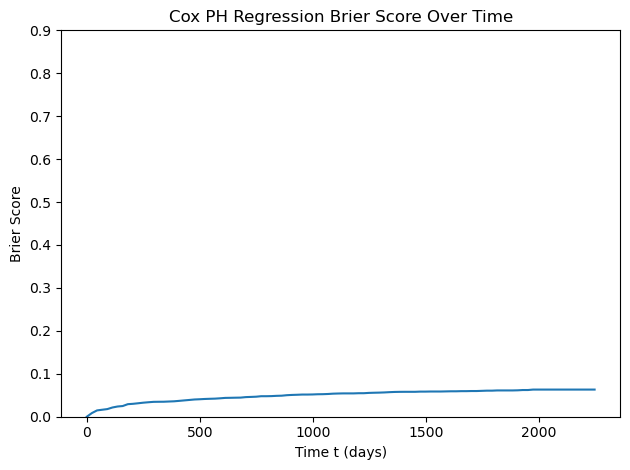

In [77]:
# Time points to evaluate
times = np.linspace(0, 2247, 100)
brier_scores = []

# Loop through time points and compute approximate Brier score
for t in times:
    surv_probs = cph.predict_survival_function(X_test, times=[t]).T[t]
    # Binary outcome: 1 if event occurred before t, else 0
    observed = ((Y_test["DaysUntilFirstProgression"] <= t) & (Y_test["Outcome"] == 1)).astype(int)
    # Approximate Brier score
    brier = brier_score_loss(observed, 1 - surv_probs)
    brier_scores.append(brier)

# Plot
plt.plot(times, brier_scores, label="Approx. Brier Score")
plt.xlabel("Time t (days)")
plt.ylabel("Brier Score")
plt.ylim(0, 0.9)
plt.title("Cox PH Regression Brier Score Over Time")
plt.tight_layout()
plt.savefig("./brier.png")
plt.show()

In [60]:
integrated_brier_score = np.trapz(brier_scores, times) / (times[-1] - times[0])
print("Test integrated brier score: ", integrated_brier_score)

Test integrated brier score:  0.04957529676925673


## Get Human Readable Content

In [61]:
cox_codes = ['Lab_1920-8',
'Lab_2500-7',
'Code_R07.9',
'Code_I10',
'Lab_718-7',
'Lab_2091-7',
'Code_E11.9',
'Lab_785-6',
'Code_R94.5',
'Lab_62292-8',
'Lab_4544-3',
'Lab_787-2',
'Code_D89.89',
'last_BMI',
'Lab_777-3',
'Lab_9830-1',
'Lab_789-8',
'Code_E55.9',
'Code_R91.8',
'Code_Z71.89']

In [62]:
lab_codes_df[lab_codes_df['Code'].isin(cox_codes)] # most positive meds

,Code,Lab Test
2,Lab_777-3,PLT (Test:mhsq-plt)
22,Lab_718-7,HGB (Test:mhsq-hgb)
24,Lab_1920-8,Transaminase-SGOT (Test:mcsq-sgot)
32,Lab_787-2,MCV (Test:mhsq-mcv)
36,Lab_789-8,RBC (Test:mhsq-rbc)
38,Lab_4544-3,HCT (Test:mhsq-hct)
56,Lab_9830-1,Cardiac Risk Ratio (Test:mcsq-crisk)
63,Lab_785-6,MCH (Test:mhsq-mch)
103,Lab_2500-7,Iron Binding Capacity (Test:mcsq-tibc)
125,Lab_62292-8,25 OH VIT D (TOTAL) (Test:mcsq-ohdt)


In [63]:
dia_df = pd.read_csv("/nobackup/users/ericason/mlhc-final-project/data/NAFLpatients_Jan2025request/Dia_all.use.final.txt", delimiter="\t", header=0)

In [64]:
dia_df.head()

,StudyID,Diagnosis_Name,Code_Type,Code,Diagnosis_Flag,Inpatient_Outpatient,Dia.Age.90,Dia.daysfrom_firstNAFL,Dia.before.ICD11
1,1,Generalized anxiety disorder,ICD10,F41.1,NaN,Outpatient,81,-1435,y
2,1,Generalized anxiety disorder,ICD10,F41.1,Primary,Outpatient,86,567,y
3,1,Unspecified symptoms and signs involving the genitourinary system,ICD10,R39.9,Primary,Outpatient,84,-97,y
4,1,Essential (primary) hypertension,ICD10,I10,NaN,Outpatient,82,-1009,y
5,1,"Disorientation, unspecified",ICD10,R41.0,NaN,Outpatient,84,-104,y


In [65]:
dia_codes = "Code_" + dia_df["Code"]

In [66]:
dia_codes_df = pd.concat([dia_codes, dia_df["Diagnosis_Name"]], axis=1)
dia_codes_df.columns = ["Code", "Diagnosis"]
dia_codes_df.head()

,Code,Diagnosis
1,Code_F41.1,Generalized anxiety disorder
2,Code_F41.1,Generalized anxiety disorder
3,Code_R39.9,Unspecified symptoms and signs involving the genitourinary system
4,Code_I10,Essential (primary) hypertension
5,Code_R41.0,"Disorientation, unspecified"


In [67]:
dia_codes_df = dia_codes_df.drop_duplicates() # drop duplicate codes and medications
dia_codes_df.shape

(26359, 2)

In [68]:
dia_codes_df[dia_codes_df['Code'].isin(cox_codes)] # most positive meds

,Code,Diagnosis
4,Code_I10,Essential (primary) hypertension
393,Code_E55.9,"Vitamin d deficiency, unspecified"
394,Code_Z71.89,Other specified counseling
724,Code_R94.5,Abnormal results of liver function studies
1181,Code_R07.9,"Chest pain, unspecified"
1300,Code_R91.8,Other nonspecific abnormal finding of lung field
1934,Code_E11.9,Type 2 diabetes mellitus without complications
2637,Code_D89.89,"Other specified disorders involving the immune mechanism, not elsewhere classified"


In [69]:
linear_nn_codes = ['Lab_4679-7',
'Lab_14338-8',
'Lab_2132-9',
'Lab_6768-6',
'Code_Z23',
'Lab_6690-2',
'Lab_2093-3',
'MedType_Code_EPIC-MED_10328',
'Lab_13457-7',
'Lab_2571-8']

In [70]:
lab_codes_df[lab_codes_df['Code'].isin(linear_nn_codes)] 

,Code,Lab Test
4,Lab_6690-2,WBC (Test:mhsq-wbc)
5,Lab_2571-8,Triglycerides (Test:mcsq-trig)
42,Lab_2093-3,Cholesterol (Test:mcsq-chol)
59,Lab_2132-9,Vitamin B12 (Test:mcsq-b12)
90,Lab_6768-6,Alkaline Phosphatase (Test:mcsq-alk)
280,Lab_4679-7,Retic (Test:mhsq-retic)
358,Lab_6690-2,WBC Blood (Test:el:5210003022)
370,Lab_2132-9,VITAMIN B12 Blood (Test:el:5200001783)
417,Lab_2571-8,TRIGLYCERIDES (Test:el:5200014087)
425,Lab_6768-6,ALKALINE PHOSPHATASE Blood (Test:el:5200001152)


In [71]:
med_codes_df[med_codes_df['Code'].isin(linear_nn_codes)] 

,Code,Medication
219,MedType_Code_EPIC-MED_10328,Iopamidol 76 % Intravenous Solution


In [72]:
dia_codes_df[dia_codes_df['Code'].isin(linear_nn_codes)] 

,Code,Diagnosis
38,Code_Z23,Encounter for immunization


In [73]:
linear2_codes = ['MedType_Code_EPIC-MED_27698',
'Lab_19153-6',
'Lab_2501-5',
'Lab_786-4',
'Code_E78.5',
'Lab_XC5-9',
'Lab_2502-3',
'MedType_Code_EPIC-MED_40900',
'Lab_2089-1',
'Lab_789-8']

In [74]:
lab_codes_df[lab_codes_df['Code'].isin(linear2_codes)] 

,Code,Lab Test
33,Lab_786-4,MCHC (Test:mhsq-mchc)
36,Lab_789-8,RBC (Test:mhsq-rbc)
49,Lab_2089-1,Low Density Lipoprotein (Test:mcsq-ldl)
315,Lab_786-4,MCHC Blood (Test:el:5200008625)
386,Lab_789-8,RBC Blood (Test:el:5200011989)
499,Lab_2089-1,LDL Blood (Test:el:5200008004)
1712,Lab_786-4,MCHC (Test:bhmchc)
1848,Lab_19153-6,TOTAL VOLUME (Test:el:5200009536)
2208,Lab_789-8,RBC (Test:bhrbc)
15088,Lab_XC5-9,VLDL (Test:el:5200015351)


In [75]:
dia_codes_df[dia_codes_df['Code'].isin(linear2_codes)] 

,Code,Diagnosis
63,Code_E78.5,"Hyperlipidemia, unspecified"


In [76]:
med_codes_df[med_codes_df['Code'].isin(linear2_codes)] 

,Code,Medication
2910,MedType_Code_EPIC-MED_40900,Flovent Hfa 110 mcg/Actuation Aerosol Inhaler
15559,MedType_Code_EPIC-MED_27698,Ondansetron 8 mg Disintegrating Tablet
